# Function and imports

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import scipy.io as scp
import copy
import random
from sklearn.model_selection import StratifiedKFold
import scipy
import math
from sklearn.linear_model import LinearRegression

#Machine learning libraries 
# %tensorflow_version 1.x
import tensorflow as tf
import keras as keras 
from keras import models 
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical
import sklearn as skl
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import regularizers    
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras.layers import BatchNormalization

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV

In [14]:
def Normalize(data1):
    D1 = copy.deepcopy(data1)
    Min = D1.min(); 
    Max = D1.max()
    D1 = (D1 - Min) / (Max - Min)
    
    return D1

def PutOffRedundant(AdjMatrix): #This function is used of vectorizing the structural connectivity matrix. 
    M = copy.deepcopy(AdjMatrix)
    for n in range(N):
        for i in range(90):
            for j in range(90):
                if i<=j:
                    M[i,j,n] = -1
    return M

def flatten_list(list_):
    new_list = []
    for i in list_:
        for j in i:
            new_list.append(j)
    return new_list


def Get_Mean_Absolute_Error(ytest, ypred):
    
    MAE_ = np.zeros(ytest.shape[0], )
    for i in range(len(ytest)):
        MAE_[i] = np.abs(ytest[i]-ypred[i])
    return np.mean(MAE_)

def Performance_Scores(ytest_5folds, ypredicted_5folds):
    
    
    for i in range(len(ytest_5folds)):
        MAE_fold = Get_Mean_Absolute_Error(ytest_5folds[i].flatten(), ypredicted_5folds[i].flatten())
        Corr_fold = scipy.stats.pearsonr(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        print('For fold', str(i+1), ', MAE =', MAE_fold, ' and Correlation =', Corr_fold[0], 'with p value =',Corr_fold[1])
        
    ytest_flat = []
    ypred_flat = []
    for i in range(len(ytest_5folds)):
        for j in range(len(ytest_5folds[i])):
            ytest_flat.append(ytest_5folds[i].flatten()[j])
            ypred_flat.append(ypredicted_5folds[i].flatten()[j])
    
    Total_MAE = Get_Mean_Absolute_Error(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())
    Total_Corr = scipy.stats.pearsonr(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())
    print('For total scores, MAE =', Total_MAE, ' and Correlation =', Total_Corr[0], 'with p value =',Total_Corr[1])
        

# Open data & preprocessing

In [9]:
#Load data from matlab struct - turn into np array, and verify shape is correct

Path_to_Connectivity = os.path.abspath('C:/Users/Yassine/Documents/3rd Year Project/Summer Work/Code/NewStructuralConnectivity.mat')
Data = scp.loadmat(Path_to_Connectivity)

PMA = np.array(Data.get('pma'))
GA = np.array(Data.get('ga'))
Sex = np.transpose(np.array(Data.get('sex')))
Structural = np.array(Data.get('SCmu'))
N = Structural.shape[2]
Names = Data.get('sub')
Subject_ID = [x.tolist()[0][4:] for x in Names[0]]

print('Number of subjects = ' , GA.shape[0])
print('Shape of Structural Matrix : ', Structural.shape)

Number of subjects =  524
Shape of Structural Matrix :  (90, 90, 524)


## Vectorizing connectome

In [5]:
# #Normalize structural connectome between 0 and 1
StructuralN = Normalize(Structural)

#Set redundant data to -1 
StrucuralNR = PutOffRedundant(StructuralN)

#Vectorise Structural connectomes 
S = np.transpose(np.reshape(StrucuralNR, (90*90, N)))

#Delete -1 elements 
Struc = S[S>-1]

#Reshape as vector of 4005 elements
X = np.reshape(Struc, (N, 4005))      

## Balance subjects on age category 

In [6]:
def Get_Equal_Density_Distribution(X, GA, PMA, Subject_ID): #This function is for balacing the distribution per age category, 
    # as described in the paper.
    
    Bins_X = []
    Bins_GA = []
    Bins_PMA = []
    Bins_Subject_ID = []
    
    
    # First, add all preterm cohort 
    for i in range(len(Subject_ID)):
        if GA[i]<37:
            
            Bins_X.append(X[i])
            Bins_GA.append(GA[i][0])
            Bins_PMA.append(PMA[i][0])
            Bins_Subject_ID.append(Subject_ID[i])

    n_preterm = len(Bins_Subject_ID) 
    
    
    # Adding term cohort
    N_Term_Per_Bins = 7 #Number of term infants per term age category. 
    
    Term_Bins = np.array([37, 38, 39, 40, 41, 42, 43])
    
    for n in range(6):
        count = 0
        for i in range(len(Subject_ID)):
            if count < N_Term_Per_Bins and GA[i]>Term_Bins[n] and GA[i]<Term_Bins[n+1]:
            
                Bins_X.append(X[i])
                Bins_GA.append(GA[i][0])
                Bins_PMA.append(PMA[i][0])
                Bins_Subject_ID.append(Subject_ID[i]) 
                 
                count = count + 1
                
    print('We have:', len(Bins_Subject_ID), 'subject in the set, including', n_preterm, 'preterm subjects')
    
    return np.array(Bins_X), np.array(Bins_GA).flatten(), np.array(Bins_PMA).flatten(), Bins_Subject_ID


In [7]:
Bins_X, Bins_GA, Bins_PMA, Bins_Subject_ID = Get_Equal_Density_Distribution(X, GA, PMA, Subject_ID)
  

We have: 145 subject in the set, including 106 preterm subjects


# Cross validation split

We do the cross validation split before entering the training loop to easily save all information of the split. This is in case we need to reproduce results later or use different methods whilst keeping the same split as described in the paper.

In [11]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)


#For saving purposes 
Train_Folds_Subjects = [] 
Test_Folds_Subjects = []

#For later use with training  
Train_Folds_Indexes = [] 
Test_Folds_Indexes = []




for train_index, test_index in skf.split(Bins_Subject_ID, np.array(Bins_GA)*0):
    
    local_train_subject_id = []
    local_test_subject_id = []
    
    for i in range(train_index.shape[0]):
        if i in train_index:
            local_train_subject_id.append(Bins_Subject_ID[i])
            
        elif i in test_index:
            local_test_subject_id.append(Bins_Subject_ID[i])
    
    #Save subject IDs of all subjects in the different folds
    Train_Folds_Subjects.append(local_train_subject_id)
    Test_Folds_Subjects.append(local_test_subject_id)
    
    #Save indexes in the connectivity matrix to assign corresponding GA
    Train_Folds_Indexes.append(train_index)
    Test_Folds_Indexes.append(test_index) 
    

# Saving fold split 
        

In [0]:
# Saving fold split subjects and split

# np.savez('Train_Fold_Subjects_GA', np.array(Train_Folds_Subjects))
# files.download('Train_Fold_Subjects_GA.npz')

# np.savez('Test_Fold_Subjects_GA', np.array(Test_Folds_Subjects))
# files.download('Test_Fold_Subjects_GA.npz')

# np.savez('Train_Fold_Indexes_GA', np.array(Train_Folds_Indexes))
# files.download('Train_Fold_Indexes_GA.npz')

# np.savez('Test_Fold_Indexes_GA', np.array(Test_Folds_Indexes))
# files.download('Test_Fold_Indexes_GA.npz')

# DNN Training

## Model definition

In [15]:
def Get_GA_DNN_Model():
    
    inputs = Input(shape=(4005,))
    x = Activation('relu')(inputs)
    x = Dense(500)(inputs) 
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)
    x = Dense(250)(x) 
    x = Activation('relu')(x)
    x = Dense(250)(x) 
    x = Activation('relu')(x)
    x = Dense(100)(x)    
    x = Activation('relu')(x)
    x = Dense(100)(x)    
    x = Activation('relu')(x)
    x = Dense(50)(x)
    x = Activation('relu')(x)
    predictions = Dense(1)(x)
    model = Model(inputs=inputs, outputs=predictions)
    Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(optimizer= Adam, loss='mse', metrics=['mae'])
    
    return model

## This function is to get bias in prediction from train/validation set. 
## This will be used to correct our predictions. 

def Get_Model_Bias(ytest, ypred): #Model linear correction
 
    model_error = ytest.reshape((-1,1)) - ypred.reshape((-1,1))

    #Find best fit for error as a function of age
    model = LinearRegression()
    Model = model.fit(ytest.reshape((-1,1)), model_error.reshape((-1,1)))
    coeff = Model.coef_
    intercept = Model.intercept_
    Parameters = [coeff, intercept]

    return Parameters


## Training

In [39]:
DNN_Correction_Parameters = []
DNN_GA_Models = []
Corrected_Predictions_DNN = []
Test_Output_5_Folds = []

for i in range(n_folds):

    # Get data from the cross validation 
    Training_Input = Bins_X[Train_Folds_Indexes[i]]
    Testing_Input = Bins_X[Test_Folds_Indexes[i]]
    
    Training_Output = Bins_GA[Train_Folds_Indexes[i]]
    Testing_Output = Bins_GA[Test_Folds_Indexes[i]]
    
    
    # Initializing tests to take model with good performance by testing on validation
    Max_Residual = 10 #max true - predicted
    Corr_Val = 0 # correlation between true and predicted
    MAE_Val = 10 # mean absolute error of true and predict
    
    while Max_Residual > 6 or Corr_Val < 0.75 or MAE_Val > 2: #Only save model if performance on validation is good enough
        
        
        # Get 15% validation set out of training sample
        xtrain, xval, ytrain, yval = train_test_split(Training_Input, Training_Output, \
                                test_size = 0.15, random_state= random.randint(0,101)) 
        
        Local_Model_GA_DNN = None 
        Local_Model_GA_DNN = Get_GA_DNN_Model()
        Training_History = Local_Model_GA_DNN.fit(xtrain, ytrain, epochs = 120, batch_size = 18, verbose=0, validation_data = (xval, yval))

        Validation_Preds = Local_Model_GA_DNN.predict(xval).flatten()

        
        MAE_Val = Local_Model_GA_DNN.evaluate(xval,yval)[1]
        Corr_Val = scipy.stats.pearsonr(yval.flatten(), Validation_Preds.flatten())[0]
        Max_Residual = np.max(np.abs(Validation_Preds-yval)) 
        print('For this validation set, results are: MAE =', MAE_Val, 'Correlation =', Corr_Val, 'max residual =', Max_Residual)
        
        Local_Parameters = Get_Model_Bias(yval, Validation_Preds)
        
    #Exited while loop - trained model is a keeper!
    
    #Compute prediction on test set
    Test_Predctions_DNN = Local_Model_GA_DNN.predict(Testing_Input).flatten()
    Test_Predctions_DNN_Bias_Corrected = Test_Predctions_DNN + Test_Predctions_DNN*Local_Parameters[0] \
                        + Local_Parameters[1]
    
    
    # Save DNN model, bias parameters and predictions into variables
    DNN_GA_Models.append(Local_Model_GA_DNN)
    DNN_Correction_Parameters.append(Local_Parameters)
    Corrected_Predictions_DNN.append(Test_Predctions_DNN_Bias_Corrected)
    Test_Output_5_Folds.append(Testing_Output)
    
    
    #Compute scores on test set
    Mean_Absolute_Error_Test = Get_Mean_Absolute_Error(Testing_Output.flatten(), Test_Predctions_DNN_Bias_Corrected.flatten())
    Correlation_Test = scipy.stats.pearsonr(np.array(Testing_Output).flatten(), np.array(Test_Predctions_DNN_Bias_Corrected).flatten())
    print('\n\nFold', (i+1), 'results: MAE =', Mean_Absolute_Error_Test, 'Correlation =', Correlation_Test[0], 'p val =', Correlation_Test[1])
    
    
print('Training successful done on all folds')   
    

18/18 [==============================] - 0s 459us/step
For this validation set, results are: MAE = 3.0428483486175537 Correlation = 0.7371978033060945 max residual = 11.193821224418947
18/18 [==============================] - 0s 483us/step
For this validation set, results are: MAE = 2.2048215866088867 Correlation = 0.915944472279681 max residual = 5.708365851943359
18/18 [==============================] - 0s 479us/step
For this validation set, results are: MAE = 2.304873466491699 Correlation = 0.8306514025034719 max residual = 5.285248896933595
18/18 [==============================] - 0s 489us/step
For this validation set, results are: MAE = 2.552255868911743 Correlation = 0.853927324923926 max residual = 6.129371643066406
18/18 [==============================] - 0s 476us/step
For this validation set, results are: MAE = 2.061861515045166 Correlation = 0.8744250890658227 max residual = 4.95022147328125
18/18 [==============================] - 0s 495us/step
For this validation set, resul

## Saving models and predictions

In [0]:
# Save models locally
for i in range(5):
    loc_model = DNN_GA_Models[i]
    loc_model.save(str('GA_DNN_Model' + str(i) + '.h5'))
    

#Save bias paramters
np.savez('Bias_Parameters_GA_DNN', np.array(DNN_Correction_Parameters))
files.download('Bias_Parameters_GA_DNN.npz')


#Save True GA
np.savez('Test_Output_5_Folds_GA', np.array(Test_Output_5_Folds))
files.download('Test_Output_5_Folds_GA.npz')

#Save Predicted GA
np.savez('Corrected_Predictions_DNN_5_Folds_GA', np.array(Corrected_Predictions_DNN))
files.download('Corrected_Predictions_DNN_5_Folds_GA.npz')

# Visualizing DNN results and performance

In [2]:
## Loading data
import pickle
Test_Fold_Subjects = np.load('GA_Folder/DNN/Test_Output_5_Folds_GA.npz')['arr_0']
Predicted_Fold_Subjects = np.load('GA_Folder/DNN/Corrected_Predictions_DNN_5_Folds_GA.npz')['arr_0']

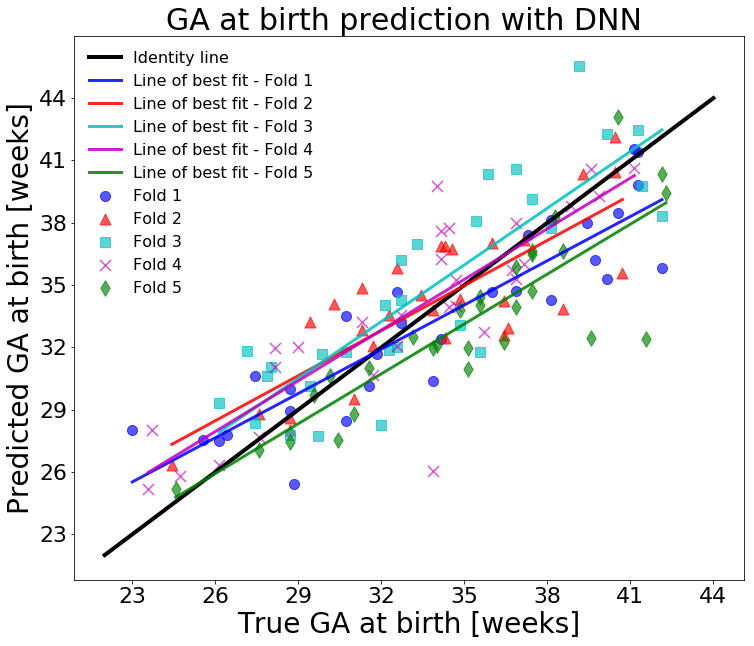

In [19]:
MARKERS = ['o', '^', 's', 'x', 'd']
COLOURS = ['b', 'r', 'c', 'm', 'g']

plt.figure(figsize = (12,10))

plt.plot([22, 44],[22, 44], label = 'Identity line', color = 'k', lw = 4)
for i in range(len(Predicted_Fold_Subjects)):
    
    True_GA = Test_Fold_Subjects[i].flatten()
    Predicted_GA = Predicted_Fold_Subjects[i].flatten()
  

    modelLR = LinearRegression()
    Model = modelLR.fit(np.array(True_GA).reshape(-1, 1), np.array(Predicted_GA).reshape(-1, 1))
    coeff = Model.coef_
    intercept = Model.intercept_
    xxx = np.linspace(min(True_GA), max(True_GA), 5).flatten()
    yyy = coeff*xxx + intercept
    
    if i == 0:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 102)
    elif i ==2:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 112)
    else:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 122)
    plt.plot(xxx, yyy.flatten(), color = COLOURS[i], label = str('Line of best fit - ' + 'Fold ' +  str(i+1)), lw = 3, alpha = 0.85)
    plt.xticks(np.arange(23,46, 3), fontsize = 22)
    plt.yticks(np.arange(23,46, 3), fontsize = 22)
    plt.xlabel('True GA at birth [weeks]', fontsize=28)
    plt.ylabel('Predicted GA at birth [weeks]',fontsize=28)
    plt.title('GA at birth prediction with DNN ', fontsize=30)
    plt.legend(fontsize = 16, loc = 2, frameon = False)
    plt.savefig('DNN_GA.png', dpi=250)
    

In [43]:
Performance_Scores(Test_Fold_Subjects, Predicted_Fold_Subjects)

For fold 1 , MAE = 2.0629829508970126  and Correlation = 0.8977213228446187 with p value = 4.109538526434078e-11
For fold 2 , MAE = 1.976108460527554  and Correlation = 0.8020032586844369 with p value = 1.6891877880564217e-07
For fold 3 , MAE = 2.4223833900228824  and Correlation = 0.8523018014842929 with p value = 4.434435636581222e-09
For fold 4 , MAE = 1.9136253855017198  and Correlation = 0.8526181208193859 with p value = 4.316411356354193e-09
For fold 5 , MAE = 2.139726111691819  and Correlation = 0.8636454592704865 with p value = 1.617618738614574e-09
For total scores, MAE = 2.1029652597281974  and Correlation = 0.8290235129069132 with p value = 6.415411042763351e-38


# Random Forest Traning

In [19]:
#We use same splits as the DNN training

#This is all using same methods and ideas as with the DNN training


RF_Correction_Parameters = []
RF_GA_Models = []
Corrected_Predictions_RF = []
Test_Output_5_Folds = []


for i in range(n_folds):

    Training_Input = Bins_X[Train_Folds_Indexes[i]]
    Testing_Input = Bins_X[Test_Folds_Indexes[i]]
    
    Training_Output = Bins_GA[Train_Folds_Indexes[i]]
    Testing_Output = Bins_GA[Test_Folds_Indexes[i]]
    
    
    # Initializing tests to take model with good performance by testing on validation
    Max_Residual = 10 #max true - predicted
    Corr_Val = 0 # correlation between true and predicted
    MAE_Val = 10 # mean absolute error of true and predict
    
    while Max_Residual > 10 or Corr_Val < 0.7 or MAE_Val > 2.8:
        
        
        # Get 15% validation set out of training sample
        xtrain, xval, ytrain, yval = train_test_split(Training_Input, Training_Output, \
                                test_size = 0.15, random_state= random.randint(0,101)) 
        
        Local_Model_GA_RF = None 
        Local_Model_GA_RF = RandomForestRegressor(max_depth= 40,max_features = 3001,
                        n_estimators= 40,
                        random_state=42)
        Local_Model_GA_RF.fit(xtrain, ytrain)
        
        
        Validation_Preds = Local_Model_GA_RF.predict(xval)
        Training_Preds = Local_Model_GA_RF.predict(xval)
        
    
        MAE_Val = Get_Mean_Absolute_Error(Validation_Preds, yval)
        Corr_Val = scipy.stats.pearsonr(yval.flatten(), Validation_Preds.flatten())[0]
        Max_Residual = np.max(Validation_Preds-yval) 
        
        Training_Preds = Local_Model_GA_RF.predict(xtrain)
        Local_Parameters = Get_Model_Bias(ytrain, Training_Preds)
        
        Both_Predictions = np.hstack((Training_Preds, Validation_Preds))
        Both_Ys = np.hstack((ytrain.flatten(), yval.flatten()))
        
        Local_Parameters = Get_Model_Bias(Both_Ys.reshape(-1, 1), Both_Predictions.reshape(-1, 1))
        
        
    #Exited while loop - trained model is a keeper!
    
    #Compute prediction on test set
    Test_Predctions_RF = Local_Model_GA_RF.predict(Testing_Input)
    Test_Predctions_RF_Bias_Corrected = Test_Predctions_RF + Test_Predctions_RF*Local_Parameters[0] \
                        + Local_Parameters[1]
    
    
    # Save DNN model, bias parameters and predictions 
    RF_GA_Models.append(Local_Model_GA_RF)
    RF_Correction_Parameters.append(Local_Parameters)
    Corrected_Predictions_RF.append(Test_Predctions_RF_Bias_Corrected[0])
    Test_Output_5_Folds.append(Testing_Output)
    
    
    #Compute scores on test set
    Mean_Absolute_Error_Test = Get_Mean_Absolute_Error(Testing_Output, Test_Predctions_RF_Bias_Corrected[0])
    Correlation_Test = scipy.stats.pearsonr(np.array(Testing_Output).flatten(), np.array(Test_Predctions_RF_Bias_Corrected[0]).flatten())
    #print('\n\nFold', (i+1), 'results: MAE =', Mean_Absolute_Error_Test, 'Correlation =', Correlation_Test[0], 'p val =', Correlation_Test[1])

    
plt.show()

print('Training successful done on all folds')   
    

Training successful done on all folds


## Save models and predictions

In [0]:
# #Save models locally
# for i in range(5):
#     loc_model = RF_GA_Models[i]
#     with open(str('GA_RF_Model' + str(i) + '.pkl'), 'wb') as f:  
#         pickle.dump(loc_model, f) 
#         files.download(str('GA_RF_Model' + str(i) + '.pkl'))
    

# #Save bias paramters
# np.savez('Bias_Parameters_GA_RF', np.array(RF_Correction_Parameters))
# files.download('Bias_Parameters_GA_RF.npz')

# #Save Predicted GA
# np.savez('Corrected_Predictions_RF_5_Folds_GA', np.array(Corrected_Predictions_RF))
# files.download('Corrected_Predictions_RF_5_Folds_GA.npz')

# RF visualization

In [20]:
## Loading data
import pickle
Test_Fold_Subjects_RF = np.load('GA stuff/RF/Test_Output_5_Folds_GA.npz')['arr_0']
Predicted_Fold_Subjects_RF = np.load('GA stuff/RF/Corrected_Predictions_RF_5_Folds_GA.npz')['arr_0']

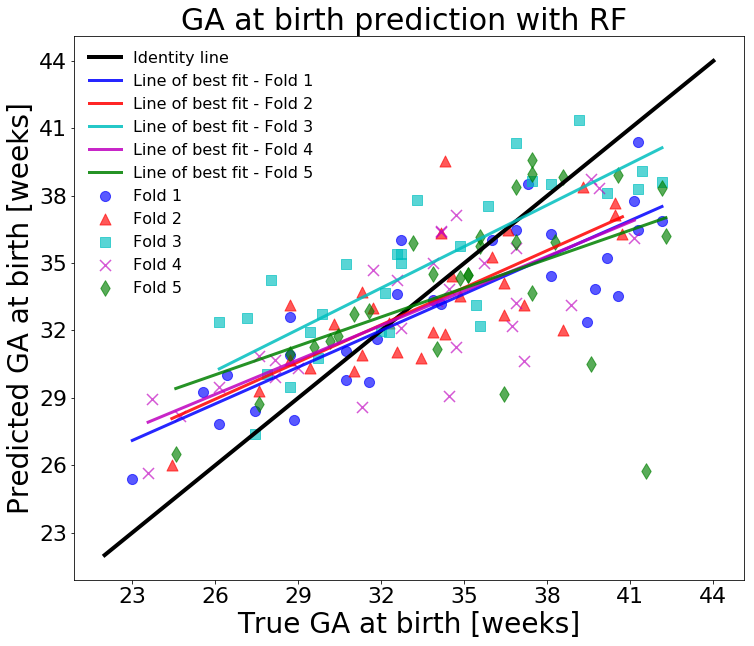

In [21]:
MARKERS = ['o', '^', 's', 'x', 'd']
COLOURS = ['b', 'r', 'c', 'm', 'g']

plt.figure(figsize = (12,10))

plt.plot([22, 44],[22, 44], label = 'Identity line', color = 'k', lw = 4)
for i in range(len(Predicted_Fold_Subjects)):
    
    True_GA = Test_Fold_Subjects_RF[i].flatten()
    Predicted_GA = Predicted_Fold_Subjects_RF[i].flatten()
  

    modelLR = LinearRegression()
    Model = modelLR.fit(np.array(True_GA).reshape(-1, 1), np.array(Predicted_GA).reshape(-1, 1))
    coeff = Model.coef_
    intercept = Model.intercept_
    xxx = np.linspace(min(True_GA), max(True_GA), 5).flatten()
    yyy = coeff*xxx + intercept
    
    if i == 0:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 102)
    elif i ==2:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 112)
    else:
        plt.scatter(True_GA, Predicted_GA, label = 'Fold %s' %str(i+1), marker = MARKERS[i], color = COLOURS[i], alpha=.65, s = 122)
    plt.plot(xxx, yyy.flatten(), color = COLOURS[i], label = str('Line of best fit - ' + 'Fold ' +  str(i+1)), lw = 3, alpha = 0.85)
    plt.xticks(np.arange(23,46, 3), fontsize = 22)
    plt.yticks(np.arange(23,46, 3), fontsize = 22)
    plt.xlabel('True GA at birth [weeks]', fontsize=28)
    plt.ylabel('Predicted GA at birth [weeks]',fontsize=28)
    plt.title('GA at birth prediction with RF ', fontsize=30)
    plt.legend(fontsize = 16, loc = 2, frameon = False)
    plt.savefig('RF_GA.png', dpi=250)
    

In [46]:
Performance_Scores(Test_Fold_Subjects_RF, Predicted_Fold_Subjects_RF)

For fold 1 , MAE = 2.58280670243884  and Correlation = 0.846364458579823 with p value = 7.275284215265938e-09
For fold 2 , MAE = 2.202413669320037  and Correlation = 0.7504778448353537 with p value = 2.751178444443862e-06
For fold 3 , MAE = 2.4924339366849724  and Correlation = 0.8143914865505842 with p value = 7.638828392829394e-08
For fold 4 , MAE = 2.7168088273581352  and Correlation = 0.7506085994794034 with p value = 2.734111291509533e-06
For fold 5 , MAE = 2.6883232125496015  and Correlation = 0.5132603309220877 with p value = 0.0044071492951604525
For total scores, MAE = 2.5365572696703174  and Correlation = 0.7193609463234444 with p value = 2.1634672273461654e-24
